# Credit Card Fraud Detection - imbalanced classification problem

# Table of contents

1. Summary
2. About the problem
3. Data preprocessing
    * 3.1. Importing libraries
    * 3.2. About data
        * 3.2.1. Importing dataset
        * 3.2.2. Dependent variable
        * 3.2.3. Missing values
    * 3.3. Feature Scaling    
    * 3.4. Splitting data into training and testing datasets
4. Sampling
    * 4.1. Under-sampling techniques applied on training dataset
    * 4.2. Over-sampling techniques
    * 4.3. Under- and over-sampling techniques combined
    * 4.4. Applying sampling techniques to training dataset
5. Modelling
    * 5.1. Fitting training datasets into a set of classifiers      
    * 5.2. Models evaluation
        * 5.2.1. Confusion matrix, precision and recall analysis
    * 5.3. Comparison - sampling techniques vs classifiers 
        * 5.3.1. Recalls, precisions vs classifiers
        * 5.3.2. Recalls, precisions vs sampling family type
        * 5.3.3. Recalls, precisions vs training dataset type
        * 5.3.4. Sampling techniques vs classifiers vs recalls and precisions

# 1. Summary

The aims of this notebook are to **deal with imbalanced dataset using sampling techniques** and **evalute performances of the classifiers** (**Logistic Regression, KNeigbors, Linear Support Vector Machine, Random Forest**). It focuses on both choosing the classifier that performance is acceptable in terms of fraud detection and **comparison** between **performance of the models** built on top of the **different sampling techniques** (**under-sampling, over-sampling and combined**). 

At the begging, the dataset is preprocessed. The feature scaling is applied, dataset is splited into training(**80%**) and test(**20%**) [while keeping **stratification** ratio]. Nextly, **23 sampling techniques** (**15** undersampling, **6** oversampling, **2** combined) are applied on the preprocessed training dataset. Notebook distinguished the division of the **sampling techniques** not only **by** their **family kind** (under-, over-, combined) but also by the **balance of the fraud class** in the obtained new datasets (balanced datasets and cleaned datasets). In the modelling chapter, **4 classifiers** are applied on **23** different training datasets. As a result, **92 models** are created. Evaluation of the models' performance is based mainly on confusion matricies, **recall** and **precision scores**. The **tradeoff (cost)** between **FP, Type I Error, precision** and **FN, Type II Error, recall** is emphasized. One of the **best models** (**benchmark**: precision **> 0.05**) that was created achieved **recall score**: **0.888** and **precision score**: **0.057** on the **test dataset**. 

In the last section, notebook visualizes **comparison between classifiers, sampling techniques** and **recall and precision scores.**

# 2. About the problem

https://www.kaggle.com/mlg-ulb/creditcardfraud

# 3. Data preprocessing

## 3.1. Importing libraries

In [1]:
#libraries
import pandas as pd
import numpy as np
from collections import Counter
import itertools
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#under sampling methods
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler,
                                     NearMiss, TomekLinks, CondensedNearestNeighbour,
                                     EditedNearestNeighbours, RepeatedEditedNearestNeighbours,
                                     AllKNN, OneSidedSelection, NeighbourhoodCleaningRule,
                                     InstanceHardnessThreshold)
from sklearn.linear_model import LogisticRegression #estimator for InstanceHardnessThreshold method

#over sampling methods
from imblearn.over_sampling import (ADASYN, RandomOverSampler, SMOTE)

#under and over sampling combined methods
from imblearn.combine import (SMOTEENN, SMOTETomek)

#evaluation
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support, precision_recall_curve,
                             average_precision_score, accuracy_score)

#feature scaling
from sklearn.preprocessing import StandardScaler

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## 3.2. About data

### 3.2.1. Importing dataset

In [2]:
#importing dataset from csv file delimited by ','
df = pd.read_csv(r'D:\SGH magisterskie\github\credit card\creditcard.csv', delimiter=',')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print("Number of rows: ",df.shape[0], "\n")

Number of rows:  284807 



Dataset imported corectly. It contains 284807 rows and 31 columns. PCA was applied to the dataframe and as a result 28 of columns are already encoded. 

In [4]:
df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

**Amount** variable informs about the trasaction amount. 

50% of the transactions concern transactions in amount of 22 or less. The maximum amount of the transaction equals to around 25691. Average amount equals to around 88.

### 3.2.2. Dependent variable

0    284315
1       492
Name: Class, dtype: int64 

 Ratio:  0.173 %


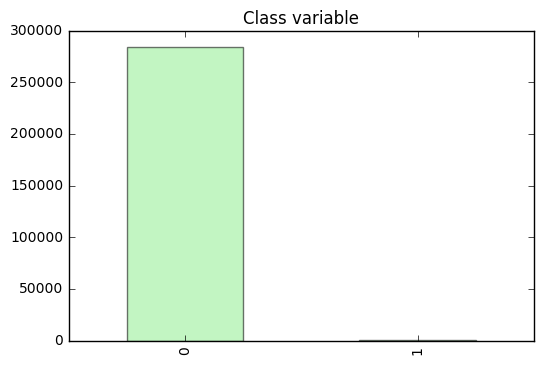

In [5]:
#dependent variable
df.Class.value_counts().plot(kind='bar', alpha=0.55, color = "lightgreen")
plt.title("Class variable");


#being more specific
print(df.Class.value_counts(),"\n\n",
      "Ratio: ", round(sum(df.Class)/len(df.Class)*100,3), "%")

Dependent variable informs about **fraud transaction**. We face the problem of very **imbalanced dataset**. Only **0.173% (492 obs)** of all transactions were fraud. To deal with such situation we need to use **sampling** methods (adding or removing observations or both) to clean or balance our dataset.

### 3.2.3. Missing values

In [6]:
#missing values?
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Furtunately, we do not encounter missing values problem. 

## 3.3. Feature Scaling 

**Amount** variable is on different scale comparing to other variables. To avoid dominance of this variable we will introduce feature scaling.

In [7]:
#feature scaling - Amount variable
feature_scaling_col = ['Amount']
sc = StandardScaler().fit(df[feature_scaling_col])
df[feature_scaling_col] = sc.transform(df[feature_scaling_col])

## 3.4. Splitting data into training and testing datasets

In [8]:
#preparing arrays
X = df.drop(["Time", "Class"], axis=1).values
y = df["Class"].values

In [9]:
#dividing dataset into training and test - stratify for keeping balance of ones
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, 
                                                    random_state = 0) 
del X, y

We splited our data into two dataframes - **training and test**. **Stratify** ensures that we will have enough ones in both dataframes (**20%** of all ones will be in the test dataset and **80%** of them in the training dataset). 

In [10]:
print("Training dataset contains: ", len(X_train), " observations. ", sum(y_train), " of them are frauds.\n"
    "Test dataset contains: ", len(X_test), " observations. ", sum(y_test), " of them are frauds.")

Training dataset contains:  227845  observations.  394  of them are frauds.
Test dataset contains:  56962  observations.  98  of them are frauds.


# 4. Sampling

Reference: http://contrib.scikit-learn.org/imbalanced-learn/stable/user_guide.html. To dive deeper in the topics that I only shortly mentioned below I recommend to check this link or bibliography the contributors point out.

## 4.1. Under-sampling techniques

**Under-sampling techniques** base on **removing observations** of the **majority class** in order to balance dataset or distinguish classes from each other. 

The undersampling techniques:

* **Cluster Centroids** - algorithm base on **K-means** to reduce number of samples. Therefore, each class will be **synthesized with the centroids** of the K-means method instead of the original samples.
* **Random Sampler** - **randomly remove majority** observations till data is balanced.
* **Near Miss** - adds heuristic rules to nearest neighbors algorithm, we distinguish 3 versions:
    * 1 - selects samples of the majority class for which **the average distance** to the N **closest samples** of the minority class is the smallest (**noise sensitive: high**)
    * 2 - selects samples of the majority class for which **the average distance** to the N **furthest samples** of the minority class is the smallest (**noise sensitive: medium [outliers]**)
    * 3 - firstly, for each minority class sample, their **M nearest neighbors are kept**. Then, the majority samples for which the **average distance** to the N nearest-neighbors is **the largest are selected** (**noise sensitive: low**)
* **Tomek's links** - the Tomek link connection appears when **two nearest neighbors have different classes**. We can decide if  
    * 1 - we want to **remove majority class** observation 
    * 2 - we want to **remove both** observations. 
* **Edited Nearest Neighbours** - for each sample in the majority class, the nearest neighbours are computed and if the selection criterion is not fulfilled, the sample is removed. There are 2 selection criteria:
    * 1 - **the majority** of the nearest neighbors have to **belong to the same class** then the sample is inspected to stay in the dataset.
    * 2 - **all samples** of the nearest neighbors have to **belong to the same class** then the sample is inspected to stay in the dataset.
* **Repeted Edited Nearest Neighbours** - extends **Edited Nearest Neighbours** by repeating the algorithm multiple times. As a result it should delete more data.
* **AllKNN** - extends **Repeted Edited Nearest Neighbours** by increasing at each iteration of the algorithm the number of neighbors.
* **Condensed Nearest Neighbour** - uses a **1 nearest neighbor rule** to iteratively decide if a **majority sample** should be **removed or not**. (**noise sensitive: high**)
* **One Sided Selection** - 1 nearest neighbor rule is applied to all samples and the one which are misclassified will be added to set C. What is more, it uses TomekLinks to remove noisy samples. (**noise sensitive: low**)
* **Neighbourhood Cleaning Rule** - focuses on cleaning the data than condesing them. It uses the union of samples to be rejected between the Edited Nearest Neighbours and the output a 3 nearest neighbors classifier.
* **Instance hardness threshold** - an algorithm in which a **classifier is trained** on the data and the observations with the **lower probabilities** are removed. 

## 4.2. Over-sampling techniques

**Oversampling techinques** base on **adding** observations of the **minority class**.

The oversampling techniques:
 * **Naive random over-sampling** - generating new samples of the minority class - most naive approach generating new samples by duplicating current samples.
 * **Adaptive Synthetic sampling method (ADASYN)** - genareting new samples by interpolation while focusing on generating samples next to the original samples which are wrongly classified using KNN classifier.
 * **Synthetic Minority Oversampling Technique (SMOTE)** - genareting new samples by interpolation. SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. There are 4 options that SMOTE technique can use:
    * 1 - **regular**
    * 2 - **borderline1** - focuses on samples near border of the optimal decision function and generates samples in the opposite direction of the nearest neighbors class
    * 3 - **borderline2** - focuses on samples near border of the optimal decision function and generates samples in the opposite direction of the nearest neighbors class
    * 4 - **svm** - focuses on samples near border of the optimal decision function and generates samples in the opposite direction of the nearest neighbors class
 

## 4.3. Under- and over-sampling techniques combined

These techniques use both under- and over-sampling techniques together.

The combined techniques:
* **SMOTETomek** - **after** applying **SMOTE** oversampling techinique the **Tomek's link** cleaning method is applied.
* **SMOTEENN** - **after** applying **SMOTE** oversampling techinique the **Edited Nearest Neighbours** cleaning method is applied.



## 4.4. Applying sampling techniques to training dataset

Firstly, we declare **sampling objects**.

In [11]:
#declaring sampling objects
RANDOM_STATE = 0

#under sampling objects
uCC = ClusterCentroids(random_state=RANDOM_STATE)
uRUS = RandomUnderSampler(random_state=RANDOM_STATE)
uNM_1 = NearMiss(version=1, random_state=RANDOM_STATE)
uNM_2 = NearMiss(version=2, random_state=RANDOM_STATE)
uNM_3 = NearMiss(version=3, random_state=RANDOM_STATE)
uTL_1 = TomekLinks(ratio='auto', random_state=RANDOM_STATE)
uTL_2 = TomekLinks(ratio='all', random_state=RANDOM_STATE)
uENN_1 = EditedNearestNeighbours(kind_sel='mode', random_state=RANDOM_STATE)
uENN_2 = EditedNearestNeighbours(kind_sel='all', random_state=RANDOM_STATE)
uRENN = RepeatedEditedNearestNeighbours(random_state=RANDOM_STATE)
uAKNN = AllKNN(random_state=RANDOM_STATE)
uCNN = CondensedNearestNeighbour(random_state=RANDOM_STATE)
uOSS = OneSidedSelection(random_state=RANDOM_STATE)
uNCR = NeighbourhoodCleaningRule(random_state=RANDOM_STATE)
uIHT = InstanceHardnessThreshold(estimator = LogisticRegression(), random_state=RANDOM_STATE)

#over sampling objects
oROS = RandomOverSampler(random_state=RANDOM_STATE)
oADASYN = ADASYN(random_state=RANDOM_STATE)
oSMOTE_1 = SMOTE(kind='regular', random_state=RANDOM_STATE)
oSMOTE_2 = SMOTE(kind='borderline1', random_state=RANDOM_STATE)
oSMOTE_3 = SMOTE(kind='borderline2', random_state=RANDOM_STATE)
oSMOTE_4 = SMOTE(kind='svm', random_state=RANDOM_STATE)

#under and over sampling combined objects
cSMOTEENN = SMOTEENN(random_state=RANDOM_STATE)
cSMOTETomek = SMOTETomek(random_state=RANDOM_STATE)

It will be more comfortable to squeze them all together in **lists**.

In [12]:
sample_objs = [uCC, uRUS, uNM_1, uNM_2, uNM_3, uTL_1, uTL_2,
               uENN_1, uENN_2, uRENN, uAKNN, uCNN, uOSS, uNCR, uIHT, 
               oROS, oADASYN, oSMOTE_1, oSMOTE_2, oSMOTE_3, oSMOTE_4,
               cSMOTEENN, cSMOTETomek]

sample_shortcuts = ["uCC", "uRUS", "uNM_1", "uNM_2", "uNM_3", "uTL_1", "uTL_2",
                    "uENN_1", "uENN_2", "uRENN", "uAKNN", "uCNN", "uOSS", "uNCR", "uIHT", 
                    "oROS", "oADASYN", "oSMOTE_1", "oSMOTE_2", "oSMOTE_3", "oSMOTE_4",
                    "cSMOTEENN", "cSMOTETomek"]

sample_names = ["Cluster Centroids", "Random Under Sampler", 
                "Near Miss - 1", "Near Miss - 2", "Near Miss - 3",
                "Tomek Links - 1", "Tomek Links - 2",
                "Edited Nearest Neighbours - 1", "Edited Nearest Neighbours - 2", 
                "Repeated Edited Nearest Neighbours", "AllKNN",
                "Condensed Nearest Neighbour", "One Sided Selection",
                "Neighbourhood Cleaning Rule", "Instance Hardness Threshold",                  
                "Random Over Sampler", "ADASYN", "SMOTE_1", "SMOTE_2", "SMOTE_3", "SMOTE_4",
                "SMOTEENN", "SMOTETomek"]                

As the amount of data is quite big we will use this loop to create new datasets and save them on the local file system instead of keeping all of these informations in memory.

In [13]:
#adjusting sampling techniques and saving results into files
#for i in len(sample_objs):
#    X_resampled, y_resampled = sample_objs[i].fit_sample(X_train, y_train)
#    np.savetxt(r"D:\SGH magisterskie\github\credit card\sampled\X" + sample_shortcuts[i] + ".csv", X_resampled, delimiter=";")
#    np.savetxt(r"D:\SGH magisterskie\github\credit card\sampled\y" + sample_shortcuts[i] + ".csv", y_resampled, delimiter=";")

#    del X_resampled, y_resampled

Let's see how do the algorithms sampled our data.

In [14]:
y_ratios = []
balance_flag = []
for i in range(len(sample_objs)):
    #loading data#        
    y_train = pd.read_csv(r"D:\SGH magisterskie\github\credit card\resampled_train\y" 
                          + sample_shortcuts[i] + ".csv", delimiter=';', header=None).values
    #ratio
    _ratio = round( (y_train.sum() / len(y_train)) * 100, 3)
    y_ratios.append(_ratio)     
    
    #balance technique flag
    balance_flag.append("balanced" if ((_ratio > 40) & (_ratio < 60)) else "not balanced")    

    #print ratios
    if i==0:
        print("Sampling technique:", ' '*(35 - len("Sampling technique:")), "Ratio:", 
              ' '*(15 - len("Ratio:")), "Is balanced?:") 
    print(sample_names[i], ' '*(35 - len(sample_names[i])), y_ratios[i],
          ' '*(15 - len(str(y_ratios[i]))), balance_flag[i]) 

Sampling technique:                  Ratio:           Is balanced?:
Cluster Centroids                    50.0             balanced
Random Under Sampler                 50.0             balanced
Near Miss - 1                        50.0             balanced
Near Miss - 2                        50.0             balanced
Near Miss - 3                        54.495           balanced
Tomek Links - 1                      0.173            not balanced
Tomek Links - 2                      0.165            not balanced
Edited Nearest Neighbours - 1        0.173            not balanced
Edited Nearest Neighbours - 2        0.173            not balanced
Repeated Edited Nearest Neighbours   0.173            not balanced
AllKNN                               0.173            not balanced
Condensed Nearest Neighbour          30.03            not balanced
One Sided Selection                  0.173            not balanced
Neighbourhood Cleaning Rule          0.173            not balanced
Instance Hardn

As we can see, we have two scenerios - our dataset is blanced or cleaned. It would be great to compare these both types. That is the reason why we created a variable - **balance_flag**. We will use it later in comparison part. 

# 5. Modelling

## 5.1. Fitting training datasets into a set of classifiers    

There are a lot of classifiers that we could use to classify a correct label to the observation. In this project we will consider 4 classifiers:
* **Logistic Regression**
* **KNeighbors Classifier**
* **Linear Support Vector Machine**
* **Random Forest Classifier**

Firstly, we initialize our classifiers. 

In [15]:
#create classifier objects
classifierLOG = LogisticRegression(random_state = 0)
classifierNEIGH =  KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifierSV_LIN = SVC(kernel = 'linear' ,random_state = 0)
classifierForest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

Then we create lists of objects, names and shortcuts.

In [16]:
#classifier lists
classifier_objs = [classifierLOG, classifierNEIGH, classifierSV_LIN, classifierForest]
classifier_shortcuts = ["LOG", "KNC", "SVM", "Forest"]
classifier_names = ["Logistic Regression", "KNeighbors Classifier", 
                    "Support Vector Machine", "Random Forest Classifier"]

We are ready to build our models. We will create **92 models** (for each **sampling technique** and **classifier** <--**23*4**). Compilation takes a while (mainly KNeighbours and SVM algorithms). So... I figured out that it would be better to save all of the predictions (**y_pred**s) on my local machine in order to not have to compile this again in case of failure and for the sake of this notebook. 

The code below builds a set of models.

In [17]:
#loading, modelling, prediction
#y_preds = []
#for m in range(len(classifier_objs)):
#    for i in range(len(sample_objs)):
#        #loading data
#        X_train = pd.read_csv(r"D:\SGH magisterskie\github\credit card\resampled_train\X" + sample_shortcuts[i] + ".csv", delimiter=';', header=None).values
#        y_train = pd.read_csv(r"D:\SGH magisterskie\github\credit card\resampled_train\y" + sample_shortcuts[i] + ".csv", delimiter=';', header=None).values
#        
#        #classifying observations   
#        classifier_objs[m].fit(X_train, y_train)
#        
#        #prediction
#        y_pred = classifier_objs[m].predict(X_test)
#        y_preds.append(y_pred)
#        np.savetxt("D:/SGH magisterskie/github/credit card/resampled_train/" + classifier_shortcuts[m] 
#                   + "_y_pred_" + sample_shortcuts[i] + ".csv", y_pred, delimiter=";")

All of the predictions are safely saved on a local machine. Finally, we can move to the model evaluation part.

## 5.2. Models evaluation

When we deal with **skewed data**, we cannot focus on maximizing accuracy. The reason for this is the high possiblity that our classifier will classify 0 to all observations. That will result with high accuracy and simultaneously our classifier will detect any anomalies. As our **goal is to detect fraud transactions** we need to focus on **minimizing first and second type errors**. To achive that we introduce:
* **Precision -** measure of result relevancy.
* **Recall -** measure of how many truly relevant results are returned.
* **F1 score -** harmonic mean of precision and recall.
* **Average precision (AP) -** weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. 

As we deal with fraud detection, we want to **minimize** as much as possible the **number of undetected fraud transations**. Moreover, we have to pay attention to **false alarms**. The **cost** that the company will pay for checking if the transaction actually was a fraud or not is a very crucial factor in selection of the model. In other words, we will try to **select** the model with **the lowest recall** score that corresponds to the **acceptable precision** score. 

### 5.2.1. Confusion matrix <- FP, FN, precision and recall analysis

**Confusion matrix** is a table that describes the performance of a classification model. It constits of:
* **true positives (TP)** - correctly predicted as 1 
* **true negatives (TN)** - correctly predicted as 0 
* **false positives (FP)** - falsely predicted as 1 ( **Type I error** - **false alarms** ) 
* **false negatives (FN)** - falsely predicted as 0 ( **Type II error**  )

Thanks to the confusion matrix we are able to calculate such metrics:
* **Accuracy** - correctly classified ratio = **(TP-TN)/total**
* **Misclassification Rate (Error Rate)** - incorrectly classified ratio = **(FP-FN)/total**
* **True Positive Rate (Recall, Sensitivity)** - when it is actually 1, how often does it predict 1 = **TP/(TP+FN)**
* **False Positive Rate** - when it is actually 0, how often does it predict 1 = **FP/(TN+FP)**
* **Specificity** - when it is actually 0, how often does it predict 0 = **TN/(TN+FP)**
* **Precision** - when it predicts 1, how offen is it actually 1 = **TP/(TP+FP)**
* **Prevalence** - how often does 1 occurs in our sample = **(TP+FN)/total**

Firstly, we need to declare a function that will plot a beautiful confusion matrix.

In [18]:
#libraries
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1 #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=None)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Now, we compute all of the needed statistics. In our analysis **recall** and **precision** are the most important. We start with importing predictions to our environment.

In [19]:
#loading y_preds from files
y_preds = []
iter_classifier = []
iter_sample = []
for m in range(len(classifier_objs)):
    for i in range(len(sample_objs)):
        _y_pred = pd.read_csv("D:/SGH magisterskie/github/credit card/resampled_train/" + classifier_shortcuts[m] 
                       + "_y_pred_" + sample_shortcuts[i] + ".csv", delimiter=';', header=None)[0].values
        y_preds.append(_y_pred)
        iter_classifier.append(classifier_shortcuts[m])
        iter_sample.append(sample_shortcuts[i])

Creation of the lists that will contain all of the needed statistics.

In [20]:
#statistics lists
cms = []
class_reports = []
precisions_1 = []
recalls_1 = []
f1_scores_1 = []
precision_curves = []
recall_curves = []
avg_precisions = []
accuracies = []
statistics = [cms, class_reports, precisions_1, recalls_1, f1_scores_1, 
              precision_curves, recall_curves, avg_precisions, accuracies]

Computing the statistics.

In [21]:
#evaluation statistics
for m in range(len(classifier_objs)):
    for i in range(len(sample_objs)):
        #selecting y_pred
        y_pred = y_preds[i + len(sample_objs) * m]
        
        #confusion matrix
        _cm = confusion_matrix(y_test, y_pred)
        cms.append(_cm)
        
        #precision, recall, f1score report
        _class_report = classification_report(y_test, y_pred)
        class_reports.append(_class_report)
        
        #precision, recall, f1score
        _precision, _recall, _fscore, _ =\
        precision_recall_fscore_support(y_test, y_pred, average='binary')
        precisions_1.append(_precision)
        recalls_1.append(_recall)
        f1_scores_1.append(_fscore)
        
        #pecision-recall curve
        _precision_curve, _recall_curve, _ = precision_recall_curve(y_test, y_pred)
        precision_curves.append(_precision_curve)
        recall_curves.append(_recall_curve)
        
        #average_precision_score - input to precision-recall curve title
        _avg_precision = average_precision_score(y_test, y_pred)
        avg_precisions.append(_avg_precision)
        
        #accuracy
        _accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(_accuracy)

One more thing, it would be easier to play around with the results if they were in pandas data frame. So...

In [22]:
#y_pred ID
id_y_pred = np.arange(0 , len(classifier_objs)*len(sample_objs), 1)

#defining dictionary
d = {'id_y_pred':id_y_pred, 'recalls_1':recalls_1,'precisions_1':precisions_1, 
     'f1_scores_1':f1_scores_1, 'avg_precisions':avg_precisions, 'accuracies':accuracies,
     'classifier':iter_classifier, 'sample':iter_sample, 'balance_flag':balance_flag*4}
#and data frame with results
results = pd.DataFrame(d, columns = ['id_y_pred', 'recalls_1', 'precisions_1', 
                                     'f1_scores_1', 'avg_precisions', 'accuracies',
                                     'classifier', 'sample', 'balance_flag'])

#heads
results.head()

,id_y_pred,recalls_1,precisions_1,f1_scores_1,avg_precisions,accuracies,classifier,sample,balance_flag
0,0,0.877551,0.045769,0.087001,0.040375,0.968312,LOG,uCC,balanced
1,1,0.887755,0.048658,0.092259,0.043389,0.969945,LOG,uRUS,balanced
2,2,0.918367,0.004324,0.008607,0.004111,0.636021,LOG,uNM_1,balanced
3,3,0.959184,0.002487,0.004961,0.002456,0.338085,LOG,uNM_2,balanced
4,4,0.744898,0.009355,0.018479,0.007408,0.863857,LOG,uNM_3,balanced


Data frame is ready. Finally, we have all that we need to evaluate our models. Let's analyze results.

In [23]:
results.sort_values(by = ['recalls_1', 'precisions_1'], ascending=[0, 0]).head(10)

,id_y_pred,recalls_1,precisions_1,f1_scores_1,avg_precisions,accuracies,classifier,sample,balance_flag
14,14,1.000000,0.002011,0.004014,0.002011,0.146273,LOG,uIHT,balanced
72,72,1.000000,0.001749,0.003491,0.001749,0.017872,Forest,uNM_2,balanced
83,83,1.000000,0.001745,0.003484,0.001745,0.015835,Forest,uIHT,balanced
37,37,1.000000,0.001744,0.003481,0.001744,0.014992,KNC,uIHT,balanced
26,26,1.000000,0.001743,0.003480,0.001743,0.014799,KNC,uNM_2,balanced
60,60,1.000000,0.001739,0.003473,0.001739,0.012570,SVM,uIHT,balanced
49,49,0.979592,0.002264,0.004518,0.002253,0.257242,SVM,uNM_2,balanced
3,3,0.959184,0.002487,0.004961,0.002456,0.338085,LOG,uNM_2,balanced
71,71,0.948980,0.001810,0.003614,0.001806,0.099628,Forest,uNM_1,balanced
2,2,0.918367,0.004324,0.008607,0.004111,0.636021,LOG,uNM_1,balanced


What is interesting, **each classifier** that was computed on the training data set that was created by **undersample Instance Hardness Threshold** has **recall** equal to **1**. We have almost the same situation for **classifiers** that were built on top of the **Near Miss undersample** technique in **version 2**. Both undersample techniques **IHT** and **NM_2** could be worth to follow if we need to detect all of the ones and do not care about false positives (no cost connected to false alarms) but on the other hand if we do not care about false positives we might as well classify all of the observations as ones. We observe that precision score and accuracy are very low. To make it more visual:

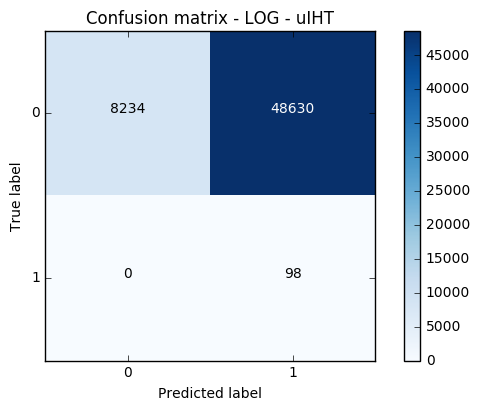

In [24]:
# Plot confusion matrix
plt.figure()
id_y_pred = 14
plot_confusion_matrix(cms[id_y_pred], classes=[0, 1], title='Confusion matrix - ' 
                      + iter_classifier[id_y_pred] + ' - ' + iter_sample[id_y_pred])
plt.show()

There are a lot of false positives. Such model could only give us an information about some group of transactions that are never frauds. As we would prefer to minimize both FN and FP, we should try to set some benchmarks to our table. 

We could say f.e. that precision over **0.05** satisfies us.

In [25]:
#benchmakrs:
recall = 0.7
precision = 0.05

#benchmarked results
benchmarked_results = results[(results['recalls_1'] >= recall) & (results['precisions_1'] >= precision)].\
                               sort_values(by = ['recalls_1', 'precisions_1'], ascending=[0, 0])
    
benchmarked_results.head(20)

,id_y_pred,recalls_1,precisions_1,f1_scores_1,avg_precisions,accuracies,classifier,sample,balance_flag
24,24,0.887755,0.064302,0.119917,0.057277,0.977582,KNC,uRUS,balanced
63,63,0.887755,0.057199,0.107474,0.050972,0.974632,SVM,oSMOTE_1,balanced
68,68,0.887755,0.057199,0.107474,0.050972,0.974632,SVM,cSMOTETomek,balanced
67,67,0.887755,0.055273,0.104067,0.049262,0.973702,SVM,cSMOTEENN,balanced
66,66,0.877551,0.148276,0.253687,0.130330,0.991117,SVM,oSMOTE_4,balanced
19,19,0.877551,0.098398,0.176955,0.086560,0.985956,LOG,oSMOTE_3,balanced
65,65,0.877551,0.091782,0.166184,0.080754,0.984850,SVM,oSMOTE_3,balanced
15,15,0.877551,0.065004,0.121042,0.057255,0.978073,LOG,oROS,balanced
61,61,0.877551,0.063798,0.118949,0.056197,0.977634,SVM,oROS,balanced
17,17,0.877551,0.059188,0.110896,0.052151,0.975791,LOG,oSMOTE_1,balanced


We can see that if our company is ready to persue this strategy we could probably choose the first possible row from the table above - **KNeighbours Classifier** built on dataset created by **Random Undersampling** technique.

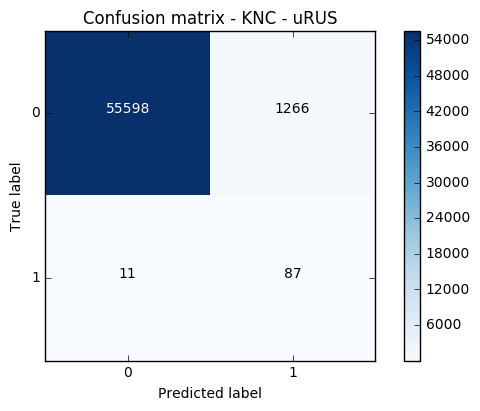

In [26]:
# Plot confusion matrix
plt.figure()
id_y_pred = 24
plot_confusion_matrix(cms[id_y_pred], classes=[0, 1], title='Confusion matrix - ' 
                      + iter_classifier[id_y_pred] + ' - ' + iter_sample[id_y_pred])
plt.show()

In [27]:
#tradeoff
print(48630-1266)

47364


As we can see, in this scenerio the company accepts to check on 1266 transactions that turned out to be false alarms. In comparison to the previous confusion matrix: **11 False Negatives** are the **tradeoff** for **47364 False Positives**. 

Now let's try to be more sensitive to the value of precision score.

In [28]:
#benchmakrs:
recall = 0.7
precision = 0.1

#benchmarked results
benchmarked_results = results[(results['recalls_1'] >= recall) & (results['precisions_1'] >= precision)].\
                        sort_values(by = ['recalls_1', 'precisions_1'], ascending=[0, 0])

As we want to visualize how the tradeoff is changing while incrementing False Negatives, we choose the max precision score for each recall group.

In [29]:
#max values of precision in recall groups
idx = benchmarked_results.groupby(['recalls_1'])['precisions_1'].transform(max) == benchmarked_results['precisions_1']

#array of benchmarked indecies
benchmarked_res_idx_arr = benchmarked_results[idx].id_y_pred.values

#heads
benchmarked_results[idx].head(15)

,id_y_pred,recalls_1,precisions_1,f1_scores_1,avg_precisions,accuracies,classifier,sample,balance_flag
66,66,0.877551,0.148276,0.253687,0.130330,0.991117,SVM,oSMOTE_4,balanced
23,23,0.867347,0.230978,0.364807,0.200567,0.994804,KNC,uCC,balanced
20,20,0.857143,0.151079,0.256881,0.129742,0.991468,LOG,oSMOTE_4,balanced
64,64,0.846939,0.123145,0.215026,0.104560,0.989361,SVM,oSMOTE_2,balanced
18,18,0.836735,0.128527,0.222826,0.107824,0.989958,LOG,oSMOTE_2,balanced
39,39,0.826531,0.462857,0.593407,0.382864,0.998051,KNC,oADASYN,balanced
40,40,0.826531,0.462857,0.593407,0.382864,0.998051,KNC,oSMOTE_1,balanced
45,45,0.826531,0.462857,0.593407,0.382864,0.998051,KNC,cSMOTETomek,balanced
41,41,0.816327,0.784314,0.800000,0.640572,0.999298,KNC,oSMOTE_2,balanced
43,43,0.816327,0.784314,0.800000,0.640572,0.999298,KNC,oSMOTE_4,balanced


Intrestingly, most of the sampling techniques that are listed above are based on SMOTE technique. It looks that in our situation models built on top of this technique are more sensitive to the precision (than in previous model) while still keeping high recall score. 

It's time to take a look at confusion matricies plots.

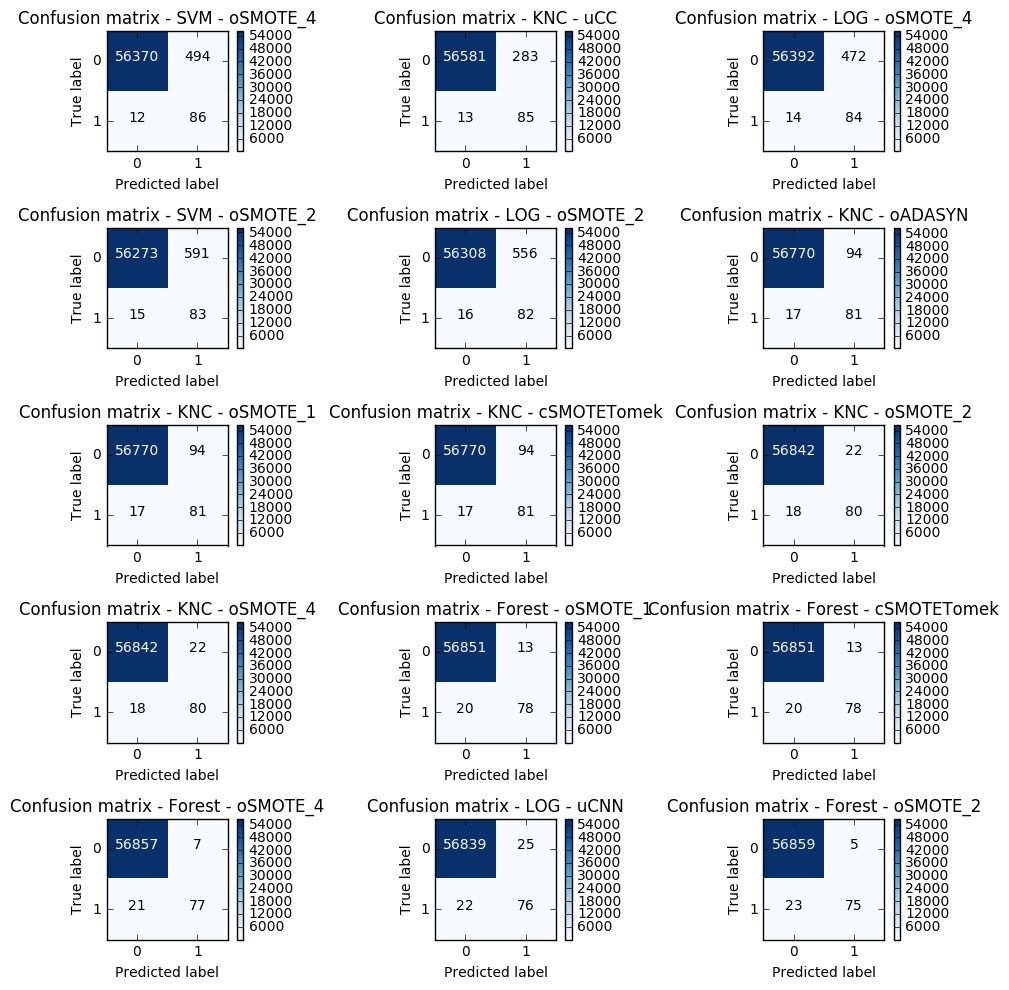

In [30]:
#confusion matricies
cm_number = 15
plt.figure(figsize=(10,10))
n_plot = 0
for i in range(0, cm_number):   
    _id_y_pred = benchmarked_res_idx_arr[i]

    #confusion matrix
    _cm = cms[_id_y_pred]

    #looping through plot spots
    n_plot += 1
    plt.subplot(math.ceil(cm_number/3), 3, n_plot)

    #plot confusion matrix
    plot_confusion_matrix(_cm, classes=[0,1], title='Confusion matrix - ' 
                          + iter_classifier[_id_y_pred] + ' - ' + iter_sample[_id_y_pred] )    

Depending on how many False Negatives we are ready to accept we could pick one of the above presented models.

In [31]:
FP = []
FN = []
for i in range(0, len(benchmarked_res_idx_arr)):
    FP.append(cms[benchmarked_res_idx_arr[i]][0][1])
    FN.append(cms[benchmarked_res_idx_arr[i]][1][0])

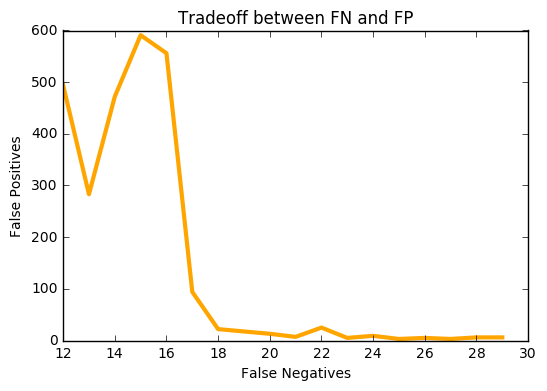

In [32]:
plt.plot(FN, FP, color ='orange', linewidth=3)
plt.title("Tradeoff between FN and FP")
plt.xlabel("False Negatives")
plt.ylabel("False Positives")
plt.show()

Base on the plot above we can see how does the tradeoff between Type I Error and Type II Error behave. We observe that False Postitives number has the highest drop from 16 to 17 False Negatives. After this point, we observe a very low values for False Positives.

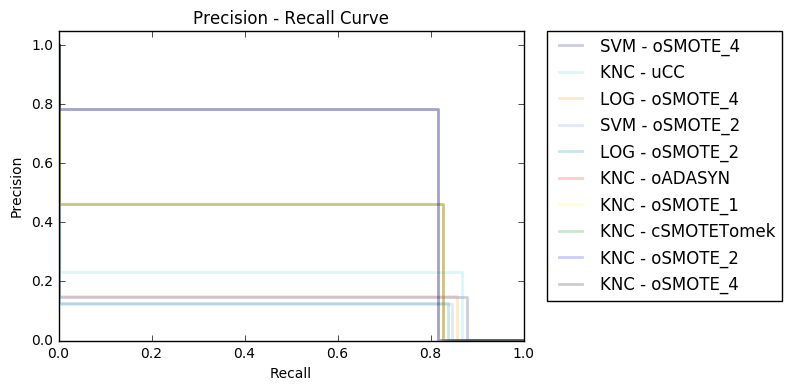

In [33]:
#libraries
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black']

take_first = 10
for i in range(0, take_first):
    id_y_pred = benchmarked_res_idx_arr[i]

    average_precision = avg_precisions[id_y_pred]
    precision = precision_curves[id_y_pred] 
    recall = recall_curves[id_y_pred]

    #precision recall curve
    plt.step(recall, precision, color=colors[i], alpha=0.2, where='post', 
             linewidth=2, label= iter_classifier[id_y_pred] + ' - ' + iter_sample[id_y_pred] )
    #plt.fill_between(recall, precision, step='post', alpha=0.2) #, color='b'
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision - Recall Curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Precision - recall curve show us the tradeoff that we have already mentioned few times.

# 5.3. Comparison - sampling techniques vs classifiers 

In this chapter we will compare how do the recall and precision score change in different groups of classifiers and sampling techniques applied on training dataset.

### 5.3.1. Recalls, precisions vs classifiers

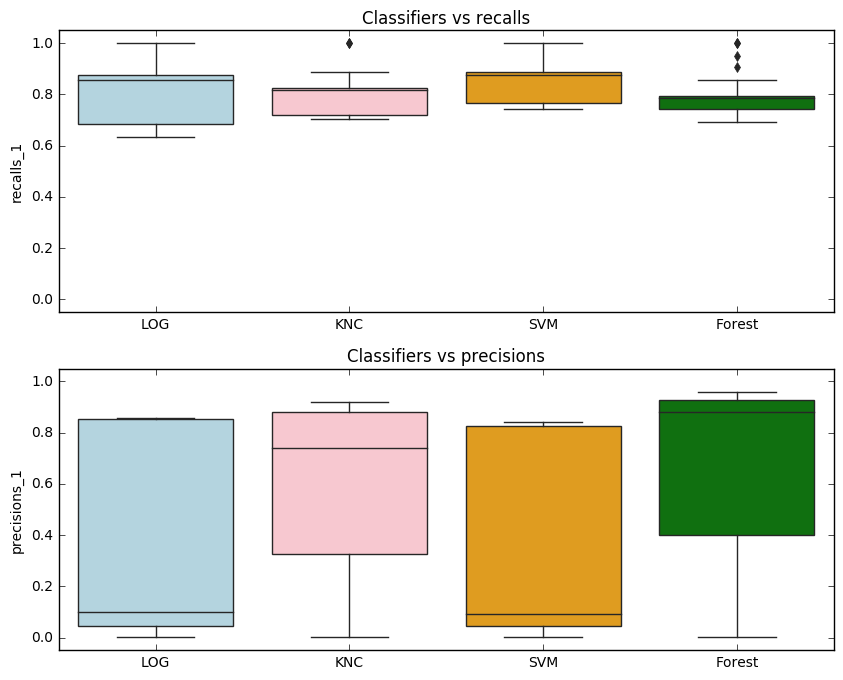

In [34]:
#colors
colors = ["lightblue","pink","orange","green"]

#subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,8))

#plots
sns.boxplot(x='classifier', y='recalls_1', data=results, palette=colors, ax=ax1)\
.set_title("Classifiers vs recalls")
sns.boxplot(x='classifier', y='precisions_1', data=results, palette=colors, ax=ax2)\
.set_title("Classifiers vs precisions")

#parameters
ax1.set_ylim(-0.05,1.05)
ax1.set(xlabel="")
ax2.set_ylim(-0.05,1.05)
ax2.set(xlabel="")
plt.show()

From the plots above we can conclude that Random Forest and KNeighbors classifiers perform very well in cases when we want to maximize both recall and precision. When it comes to Logistic Regression and Linear Support Vector Machine they seem to pay more attention to recall score than Random Forest and KNC. Unfortunatelly, the cost of this is very low precision score. 

### 5.3.2. Recalls, precisions vs sampling family type

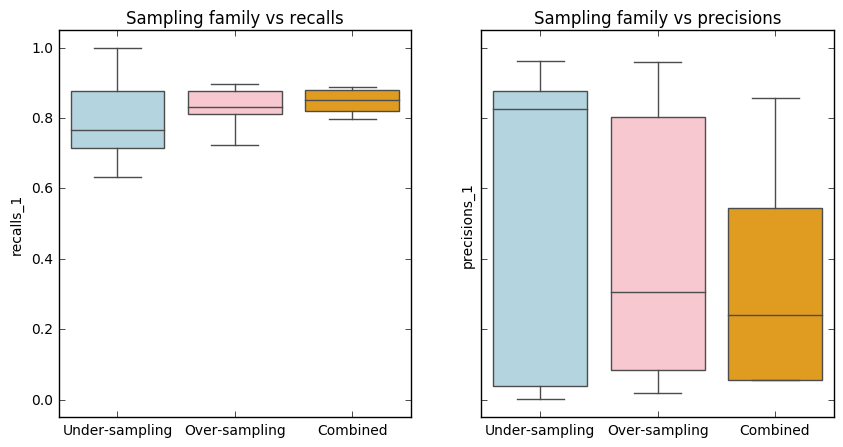

In [35]:
#sample name column
results["sample_family"] = results["sample"].str[:1] 

#colors
colors =["lightblue","pink","orange"]

#subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

#first plot
sns.boxplot(x='sample_family', y='recalls_1', data=results, palette=colors, ax=ax1)\
.set_title("Sampling family vs recalls")

#second plot
sns.boxplot(x='sample_family', y='precisions_1', data=results, palette=colors, ax=ax2)\
.set_title("Sampling family vs precisions")

#parameters
ax1.set_xticklabels(['Under-sampling','Over-sampling','Combined'])
ax1.set(xlabel="")
ax1.set_ylim(-0.05,1.05)

ax2.set_xticklabels(['Under-sampling','Over-sampling','Combined'])
ax2.set(xlabel="")
ax2.set_ylim(-0.05,1.05)
plt.show()

Sampling techniques play a key role in imbalanced dataset classification. As we can see, thanks to over-sampling techniques and combined techniques we achieved for the first 50% of the cases low precisions while the median of under-sampling techniques is much higher. 

### 5.3.3. Recalls, precisions vs training dataset type

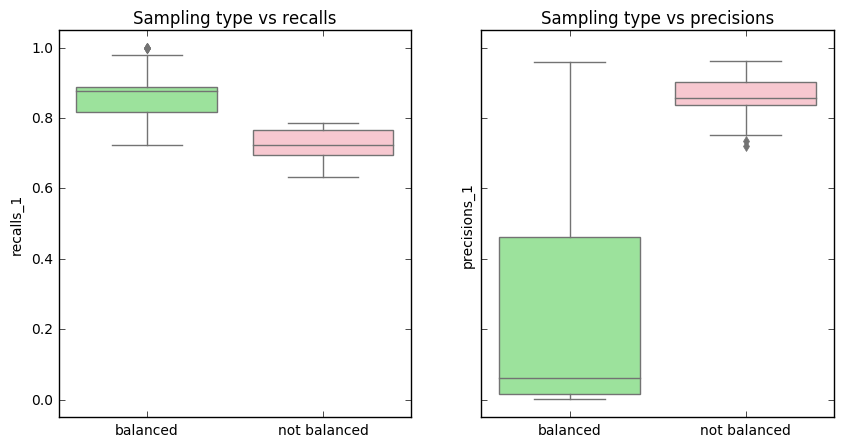

In [36]:
#colors
colors = ["lightgreen","pink"]

#subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

#first plot
sns.boxplot(x='balance_flag', y='recalls_1', data=results, palette=colors, ax=ax1)\
.set_title("Sampling type vs recalls")

#second plot
sns.boxplot(x='balance_flag', y='precisions_1', data=results, palette=colors, ax=ax2)\
.set_title("Sampling type vs precisions")

#parameters
ax1.set(xlabel="")
ax1.set_ylim(-0.05,1.05)

ax2.set(xlabel="")
ax2.set_ylim(-0.05,1.05)

plt.show()

Intersting thing is that sampling techniques that are created on balanced datasets tend to have high recall score and low precision. On the other hand, we have sampling techniques that are more about cleaning dataset (than balance it) and these techniques pay a lot of attention to precision score while keeping quite acceptable recall score.

### 5.3.4. Sampling techniques vs classifiers vs recalls and precisions

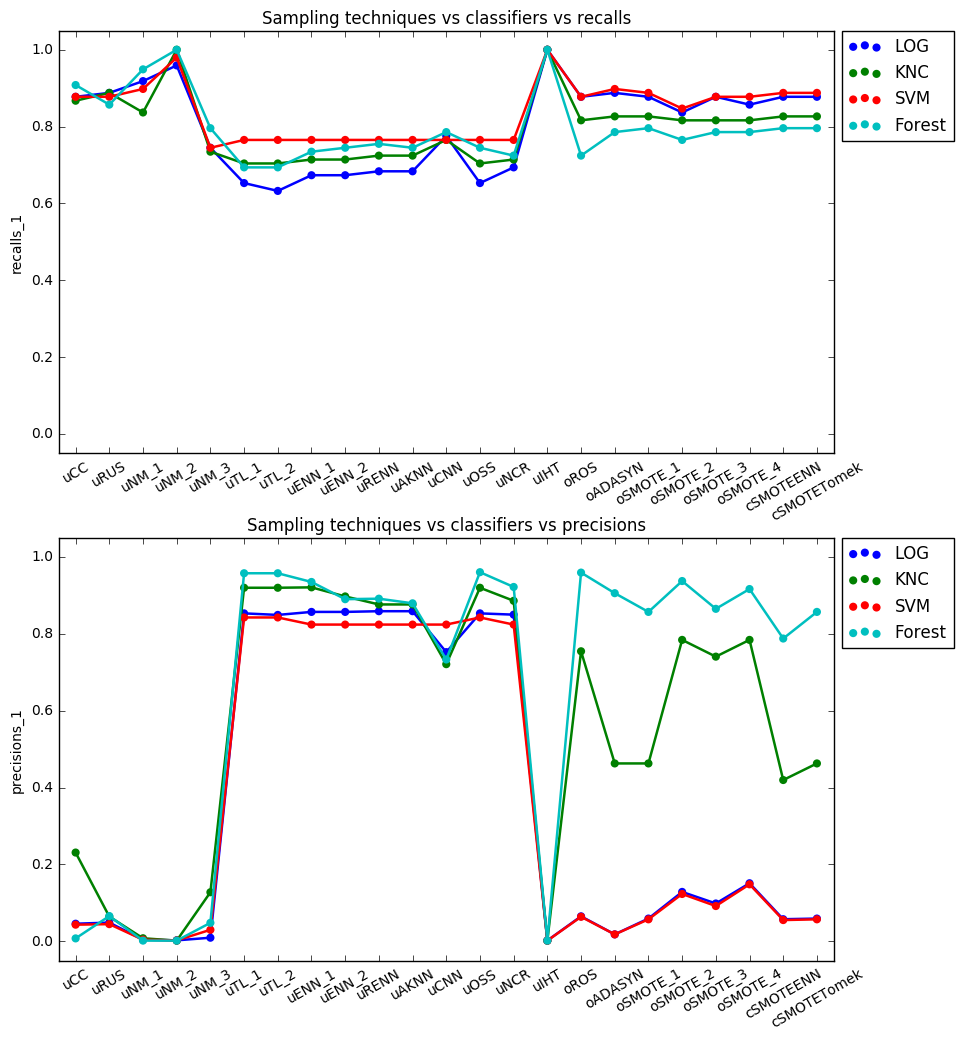

In [37]:
#subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,12))

#plots
sns.factorplot(x='sample', y='recalls_1',  hue="classifier", data=results, ax=ax1)
sns.factorplot(x='sample', y='precisions_1',  hue="classifier", data=results, ax=ax2)

#parameters
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 30)
ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax1.set_ylim(-0.05,1.05)
ax1.set(xlabel="")
ax1.set_title("Sampling techniques vs classifiers vs recalls")

ax2.set_xticklabels(ax1.get_xticklabels(), rotation = 30)
ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax2.set_ylim(-0.05,1.05)
ax2.set(xlabel="")
ax2.set_title("Sampling techniques vs classifiers vs precisions")

#dealing with empty plots
plt.close()
plt.close()

plt.show() 

The plots above present **the levels of the recall and precision scores** **for each classifier** that were built on top of **each sampling technique**. **Linear Support Vector Machine** tends to achieve **the highest recall scores for most of the sampling techniques** and **the lowest precision** scores. **Each classifier** built on top of the **undersampling techniqes based on cleaning dataset** (not balancing it) pay more attention to keep btoh **high recall and precision**. What is more, **KNeigbours** and **Random Forest** classifiers (built on top of the **oversampling** and **combined** techniques) still reach **higher precision scores** but as a result they perform **worse** in **recall scores** than **Logistic Regression** and **Linear Support Vector Machine**. It seems that **Random Forest** is the best in **high precision scores** and **SVMs** are the best in **high recall scores**.